In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
def load_dataset(name, lable_in_last):
    path = os.path.join("..", "datasets", name)
    data = pd.read_csv(path)
    data = data.values
    if lable_in_last:
        xs = data[:, :-1].astype('float32')
        ys = data[:, -1]
    else:
        xs = data[:, 1:].astype('float32')
        ys = data[:, 0]
    return xs, ys

In [3]:
spam_x, spam_y = load_dataset("spam.csv", True)
cancer_x, cancer_y = load_dataset("cancer.csv", False)

In [4]:
spam_train_x, spam_val_x, spam_train_y, spam_val_y = train_test_split(
    spam_x, spam_y, test_size=0.2)
cancer_train_x, cancer_val_x, cancer_train_y, cancer_val_y = train_test_split(
    cancer_x, cancer_y, test_size=0.2)

In [5]:
class Tree:
    class Node:
        def __init__(self, dep, l=None, r=None, f_indx=None, val=None, probs=None):
            self.dep = dep
            self.l = l
            self.r = r
            self.f_indx = f_indx
            self.val = val
            self.probs = probs
        
    def __init__(self, depth):
        self.depth = depth
        self.root = Tree.Node(0)
        
    def calc_probs(self, ys):
        n = ys.shape[0]
        if n is 0:
            return np.zeros(self.clss_all.shape)
        clss, cnts = np.unique(ys, return_counts=True)
        ys_clss_cnts = dict(zip(clss, cnts))
        probs = [ys_clss_cnts.get(c, 0) / n for c in self.clss_all]
        return np.array(probs)
        
    def do_split(f_indx, val, xs, ys=None, return_indxs=False):
        l_indxs = xs[:, f_indx] < val
        r_indxs = np.invert(l_indxs)
        
        if ys is None:
            res = (xs[l_indxs], xs[r_indxs])
        else:
            res = ((xs[l_indxs], xs[r_indxs]), (ys[l_indxs], ys[r_indxs]))
            
        if not return_indxs:
            return res
        else:
            return res, (l_indxs, r_indxs)
        
    def calc_gini(y1, y2):
        n = y1.shape[0] + y2.shape[0]
        gini = 0.0
        for y in [y1, y2]:
            ny = y.shape[0]
            if ny == 0:
                continue
            
            _, cnts = np.unique(y, return_counts=True)
            s = np.sum(cnts ** 2) / ny ** 2
            gini += (1.0 - s) * (ny / n)
        return gini
    
    def find_feature_to_split(xs, ys):
        n = xs.shape[0]
        f_cnt = xs.shape[1]
        
        ginis = np.ones((f_cnt, n))
        for f_indx in range(f_cnt):
            for i in range(n):
                val = xs[i, f_indx]
                _, (l_ys, r_ys) = Tree.do_split(f_indx, val, xs, ys)
                ginis[f_indx, i] = Tree.calc_gini(l_ys, r_ys)
                
        f_indx, i = np.unravel_index(np.argmin(ginis, axis=None), ginis.shape)
        return f_indx, xs[i, f_indx]
        
    def split_node(self, node, xs, ys):
        clss_cnt = np.unique(ys).shape[0]
        if (clss_cnt == 1) or (node.dep == self.depth):
            node.probs = self.calc_probs(ys)
            return
        
        f_indx, val = Tree.find_feature_to_split(xs, ys)
        (l_xs, r_xs), (l_ys, r_ys) = Tree.do_split(f_indx, val, xs, ys)
        
        node.l = Tree.Node(node.dep + 1)
        node.r = Tree.Node(node.dep + 1)
        node.f_indx = f_indx
        node.val = val
        
        self.split_node(node.l, l_xs, l_ys)
        self.split_node(node.r, r_xs, r_ys)
        
    def build(self, xs, ys):
        self.clss_all = np.unique(ys)
        self.root = Tree.Node(0)
        self.split_node(self.root, xs, ys)
        
    def get_probs_for_node(node, xs):
        if xs.shape[0] == 0:
            return None
        
        if node.probs is not None:
            return np.array([node.probs] * xs.shape[0])
        
        (l_xs, r_xs), (l_indxs, r_indxs) = Tree.do_split(node.f_indx, node.val, xs, return_indxs=True)
        l_probs = Tree.get_probs_for_node(node.l, l_xs)
        r_probs = Tree.get_probs_for_node(node.r, r_xs)
        
        if l_probs is None:
            return r_probs
        elif r_probs is None:
            return l_probs
        else:
            res = np.zeros((xs.shape[0], l_probs.shape[1]))
            res[l_indxs] = l_probs
            res[r_indxs] = r_probs
            return res
        
    def get_probs(self, xs):
        return Tree.get_probs_for_node(self.root, xs)
        
    def predict(self, xs):
        return self.clss_all[np.argmax(self.get_probs(xs), axis=1)]

In [6]:
def task_9(train_x, val_x, train_y, val_y, dataset_name):
    depths = list(range(1, 11))
    
    trees = []
    accs = []
    for dep in depths:
        tree = Tree(dep)
        tree.build(train_x, train_y)
        acc = accuracy_score(val_y, tree.predict(val_x))
        accs.append(acc)
        trees.append(tree)
        
    plt.plot(depths, accs)
    plt.title("Trees accuracies for dataset '{}'".format(dataset_name))
    plt.show()
        
    accs = np.array(accs)
    best_depth = np.argmax(accs)
    print("Best accuracy for depth = {}".format(depths[best_depth]))
    
    probs = trees[best_depth].get_probs(val_x)
    fpr, tpr, _ = roc_curve(val_y, probs[:, 1], pos_label=trees[best_depth].clss_all[1])
    
    plt.plot(fpr, tpr)
    plt.title("ROC, dataset '{}', depth {}".format(dataset_name, depths[best_depth]))
    plt.show()
    
    auc = roc_auc_score(val_y, probs[:, 1])
    print("For depth = {}, AUC score = {}".format(depths[best_depth], auc))

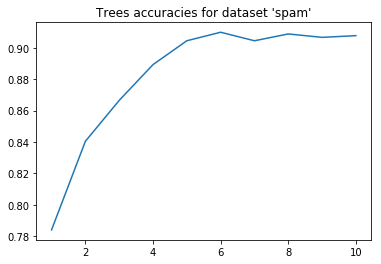

Best accuracy for depth = 6


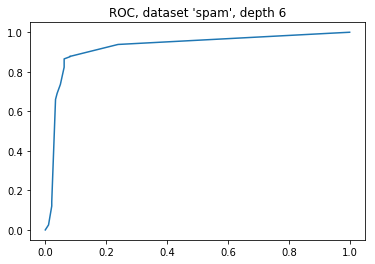

For depth = 6, AUC score = 0.9242940240628418


In [7]:
task_9(spam_train_x, spam_val_x, spam_train_y, spam_val_y, "spam")

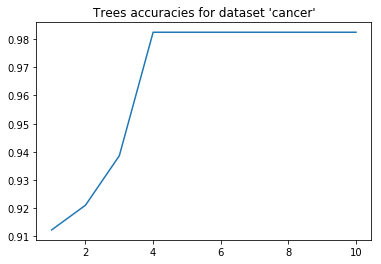

Best accuracy for depth = 4


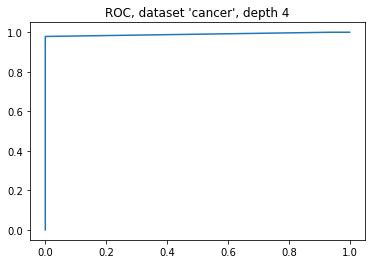

For depth = 4, AUC score = 0.9899968243886947


In [8]:
task_9(cancer_train_x, cancer_val_x, cancer_train_y, cancer_val_y, "cancer")